# CSE 251B Project Milestone Problem 2 Code

In [49]:
# from starter file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from typing import Dict, List, Tuple
import os
import time
import tqdm
import itertools


train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


Disclaimer: some code taken from starter code notebook and some code is referenced from AI sources (i.e. ChatGPT)

### Problem 2A - Searching for the optimal parameters to train our model on

In [ ]:
# decided to use the Adam optimizer
# define hyperparameter search space
search_params = {
    'learning_rate': [1e-2, 5e-3, 1e-3, 5e-4],
    'weight_decay': [1e-3, 1e-4, 1e-5, 0.0],
    'step_size': [10, 20, 30],
    'gamma': [0.5, 0.25, 0.1]
}

# define model to use for the search (LSTM in this case)
model_kwargs = {
    'input_dim': 6,
    'hidden_dim': 128,
    'output_dim': 60*2
}

In [9]:
def hyperparameter_search(
    train_data: np.ndarray,
    model_class,
    model_kwargs: Dict = {},
    search_params: Dict = None,
    batch_size: int = 32,
    val_ratio: float = 0.1,
    scale: float = 7.0,
    max_epochs: int = 30,
    early_stopping_patience: int = 5,
    device: torch.device = None,
    results_dir: str = 'hyperparameter_search_results',
    verbose: bool = True
):
    """
    Perform hyperparameter search for trajectory prediction model.
    
    Args:
        train_data: Training data
        model_class: Model class to instantiate
        model_kwargs: Additional model parameters
        search_params: Dictionary of parameters to search over
        batch_size: Batch size for training
        val_ratio: Proportion of data to use for validation
        scale: Scale factor for normalization
        max_epochs: Maximum number of epochs to train
        early_stopping_patience: Number of epochs to wait before early stopping
        device: Device to train on
        results_dir: Directory to save results
        verbose: Whether to print progress
        
    Returns:
        results_df: DataFrame of results
        best_params: Best parameters found
    """
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
            print("Using Apple Silicon GPU")
        elif torch.cuda.is_available():
            device = torch.device('cuda')
            print("Using CUDA GPU")
        else:
            device = torch.device('cpu')
            print("Using CPU")
    
    if search_params is None:
        search_params = {
            'learning_rate': [1e-2, 1e-3, 5e-4],
            'weight_decay': [1e-4, 1e-5, 0.0],
            'step_size': [10, 20, 30],
            'gamma': [0.5, 0.25, 0.1]
        }
    
    # Create directory for results
    os.makedirs(results_dir, exist_ok=True)
    
    # Prepare the data
    N = len(train_data)
    val_size = int(val_ratio * N)
    train_size = N - val_size
    
    # Create datasets
    train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    # Generate parameter combinations
    param_grid = list(ParameterGrid(search_params))
    if verbose:
        print(f"Testing {len(param_grid)} parameter combinations")
    
    # Initialize results tracking
    results = []
    
    # Run hyperparameter search
    for param_idx, params in enumerate(param_grid):
        if verbose:
            print(f"\nParameter set {param_idx+1}/{len(param_grid)}: {params}")
        
        # Create model
        model = model_class(**model_kwargs).to(device)
        
        # Setup optimizer and scheduler
        optimizer = optim.Adam(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=params['step_size'],
            gamma=params['gamma']
        )
        
        # Track best validation loss
        best_val_loss = float('inf')
        no_improvement = 0
        criterion = nn.MSELoss()
        
        # Track metrics
        train_losses = []
        val_losses = []
        val_maes = []
        val_mses = []
        epoch_times = []
        
        # Training loop
        for epoch in range(max_epochs):
            start_time = time.time()
            
            # ---- Training ----
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                loss = criterion(pred, y)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # ---- Validation ----
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch = batch.to(device)
                    pred = model(batch)
                    y = batch.y.view(batch.num_graphs, 60, 2)
                    val_loss += criterion(pred, y).item()
                    
                    # Unnormalize for metric calculation
                    pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    
                    val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                    val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
            
            # Calculate average losses
            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)
            
            # Step scheduler
            scheduler.step()
            
            # Track time
            epoch_time = time.time() - start_time
            epoch_times.append(epoch_time)
            
            # Track metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_maes.append(val_mae)
            val_mses.append(val_mse)
            
            if verbose:
                print(f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
                      f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
                      f"Val MAE {val_mae:.4f} | Val ADE {val_mae:.4f} | "
                      f"Time {epoch_time:.2f}s")
            
            # Check for improvement
            if val_loss < best_val_loss - 1e-3:
                best_val_loss = val_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch}")
                    break
        
        # Record results for this parameter set
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        best_epoch = val_losses.index(min(val_losses))
        
        param_results = {
            **params,
            'best_val_loss': min(val_losses),
            'best_val_mae': val_maes[best_epoch],
            'best_val_mse': val_mses[best_epoch],
            'best_epoch': best_epoch,
            'epoch_time_seconds': avg_epoch_time,
            'total_epochs': len(train_losses)
        }
        
        results.append(param_results)
        
        # Create and save training curve plot
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Curves')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(val_maes, label='MAE (meters)')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Validation MAE')
        
        plt.subplot(2, 2, 3)
        lr_values = [optimizer.param_groups[0]['lr'] * (params['gamma'] ** (i // params['step_size'])) 
                     for i in range(len(train_losses))]
        plt.plot(lr_values)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        
        plt.subplot(2, 2, 4)
        plt.bar(['Learning Rate', 'Weight Decay', 'Step Size', 'Gamma'], 
                [params['learning_rate'], params['weight_decay'], params['step_size'], params['gamma']])
        plt.title('Hyperparameters')
        plt.yscale('log')
        
        plt.tight_layout()
        plt.savefig(f"{results_dir}/params_{param_idx+1}_plot.png")
        plt.close()
        
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by validation MAE
    results_df = results_df.sort_values('best_val_mae')
    
    # Save results
    results_df.to_csv(f"{results_dir}/hyperparameter_search_results.csv", index=False)
    
    # Get best parameters
    best_params = results_df.iloc[0].to_dict()
    
    # Plot comparative results
    plt.figure(figsize=(15, 10))
    
    param_labels = [f"lr={p['learning_rate']:.0e}, wd={p['weight_decay']:.0e}, ss={p['step_size']}, γ={p['gamma']}" 
                   for _, p in results_df.iloc[:10].iterrows()]
    
    plt.subplot(2, 2, 1)
    plt.barh(param_labels, results_df['best_val_mae'].iloc[:10])
    plt.xlabel('MAE (meters)')
    plt.title('Top 10 Parameter Sets by MAE')
    
    plt.subplot(2, 2, 2)
    plt.barh(param_labels, results_df['best_val_mse'].iloc[:10])
    plt.xlabel('MSE (square meters)')
    plt.title('MSE for Top 10 Parameter Sets')
    
    plt.subplot(2, 2, 3)
    plt.barh(param_labels, results_df['epoch_time_seconds'].iloc[:10])
    plt.xlabel('Average Epoch Time (seconds)')
    plt.title('Training Time for Top 10 Parameter Sets')
    
    plt.subplot(2, 2, 4)
    plt.barh(param_labels, results_df['best_epoch'].iloc[:10])
    plt.xlabel('Best Epoch')
    plt.title('Convergence Speed for Top 10 Parameter Sets')
    
    plt.tight_layout()
    plt.savefig(f"{results_dir}/comparative_results.png")
    plt.close()
    
    if verbose:
        print("\nHyperparameter search complete!")
        print(f"Best parameters: {best_params}")
    
    return results_df, best_params


In [10]:
def visualize_hyperparameter_effects(results_df: pd.DataFrame, save_path: str = None):
    """
    Visualize the effects of different hyperparameters on model performance.
    
    Args:
        results_df: DataFrame of hyperparameter search results
        save_path: Path to save the visualization
    """
    plt.figure(figsize=(16, 12))
    
    # Effect of learning rate
    plt.subplot(2, 2, 1)
    lr_groups = results_df.groupby('learning_rate')['best_val_mae'].mean().reset_index()
    plt.bar(lr_groups['learning_rate'].astype(str), lr_groups['best_val_mae'])
    plt.xlabel('Learning Rate')
    plt.ylabel('Average MAE (meters)')
    plt.title('Effect of Learning Rate on MAE')
    
    # Effect of weight decay
    plt.subplot(2, 2, 2)
    wd_groups = results_df.groupby('weight_decay')['best_val_mae'].mean().reset_index()
    plt.bar(wd_groups['weight_decay'].astype(str), wd_groups['best_val_mae'])
    plt.xlabel('Weight Decay')
    plt.ylabel('Average MAE (meters)')
    plt.title('Effect of Weight Decay on MAE')
    
    # Effect of step size
    plt.subplot(2, 2, 3)
    ss_groups = results_df.groupby('step_size')['best_val_mae'].mean().reset_index()
    plt.bar(ss_groups['step_size'].astype(str), ss_groups['best_val_mae'])
    plt.xlabel('Step Size')
    plt.ylabel('Average MAE (meters)')
    plt.title('Effect of Step Size on MAE')
    
    # Effect of gamma
    plt.subplot(2, 2, 4)
    gamma_groups = results_df.groupby('gamma')['best_val_mae'].mean().reset_index()
    plt.bar(gamma_groups['gamma'].astype(str), gamma_groups['best_val_mae'])
    plt.xlabel('Gamma')
    plt.ylabel('Average MAE (meters)')
    plt.title('Effect of Gamma on MAE')
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()


In [11]:
def run_best_model_training(
    train_data: np.ndarray,
    model_class,
    model_kwargs: Dict = {},
    best_params: Dict = None,
    batch_size: int = 32,
    val_ratio: float = 0.1,
    scale: float = 7.0,
    max_epochs: int = 100,
    early_stopping_patience: int = 10,
    device: torch.device = None,
    save_model_path: str = 'best_model.pt',
    verbose: bool = True
):
    """
    Train a model with the best hyperparameters.
    
    Args:
        train_data: Training data
        model_class: Model class to instantiate
        model_kwargs: Additional model parameters
        best_params: Best hyperparameters from search
        batch_size: Batch size for training
        val_ratio: Proportion of data to use for validation
        scale: Scale factor for normalization
        max_epochs: Maximum number of epochs to train
        early_stopping_patience: Number of epochs to wait before early stopping
        device: Device to train on
        save_model_path: Path to save the best model
        verbose: Whether to print progress
        
    Returns:
        trained_model: Trained model
        history: Training history
    """
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
            print("Using Apple Silicon GPU")
        elif torch.cuda.is_available():
            device = torch.device('cuda')
            print("Using CUDA GPU")
        else:
            device = torch.device('cpu')
            print("Using CPU")
    
    if best_params is None:
        best_params = {
            'learning_rate': 1e-3,
            'weight_decay': 1e-4,
            'step_size': 20,
            'gamma': 0.25
        }
    
    # Prepare the data
    N = len(train_data)
    val_size = int(val_ratio * N)
    train_size = N - val_size
    
    # Create datasets
    train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    # Create model
    model = model_class(**model_kwargs).to(device)
    
    # Setup optimizer and scheduler
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=best_params['step_size'],
        gamma=best_params['gamma']
    )
    
    # Track best validation loss
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()
    
    # Track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_mse': [],
        'learning_rate': []
    }
    
    # Training loop
    start_time = time.time()
    for epoch in tqdm(range(max_epochs), desc="Training with best parameters"):
        epoch_start = time.time()
        
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()
                
                # Unnormalize for metric calculation
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
        
        # Calculate average losses
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        
        # Step scheduler
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Track metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_mse'].append(val_mse)
        history['learning_rate'].append(current_lr)
        
        epoch_time = time.time() - epoch_start
        
        if verbose:
            print(f"Epoch {epoch:03d} | LR {current_lr:.6f} | "
                  f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
                  f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f} | "
                  f"Time {epoch_time:.2f}s")
        
        # Check for improvement
        if val_loss < best_val_loss - 1e-3:
            best_val_loss = val_loss
            no_improvement = 0
            # Save best model
            torch.save(model.state_dict(), save_model_path)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
    
    total_time = time.time() - start_time
    if verbose:
        print(f"Training completed in {total_time:.2f} seconds")
        print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(save_model_path))
    
    # Create and save training curve plot
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Curves')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(history['val_mae'], label='MAE (meters)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Validation MAE')
    
    plt.subplot(2, 2, 3)
    plt.plot(history['learning_rate'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    
    plt.subplot(2, 2, 4)
    plt.plot(history['val_mse'], label='MSE (square meters)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Validation MSE')
    
    plt.tight_layout()
    plt.savefig("best_model_training_curves.png")
    
    return model, history


In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [ ]:
# took 2-3 hours to run on original notebook, so skipping running here
# results loaded in markdown cell below as well as in the listed files 
# run hyperparameter search
print("Starting hyperparameter search...")
results_df, best_params = hyperparameter_search(
    train_data=train_data,
    model_class=LSTM,
    model_kwargs=model_kwargs,
    search_params=search_params,
    batch_size=32,
    max_epochs=50,
    results_dir='lstm_hyperparameter_search'
)

# visualize hyperparameter effects
print("Visualizing hyperparameter effects...")
visualize_hyperparameter_effects(
    results_df=results_df,
    save_path='lstm_hyperparameter_effects.png'
)

# train best model
print("Training final model with best hyperparameters...")
best_model, history = run_best_model_training(
    train_data=train_data,
    model_class=LSTM,
    model_kwargs=model_kwargs,
    best_params=best_params,
    max_epochs=100,
    save_model_path='lstm_best_model.pt'
)

print("Done!")

Best parameters: {'gamma': 0.5, 'learning_rate': 0.005, 'step_size': 10.0, 'weight_decay': 0.0, 'best_val_loss': 0.1667313063517213, 'best_val_mae': 1.339437248185277, 'best_val_mse': 8.169826827943325, 'best_epoch': 37.0, 'epoch_time_seconds': 4.156487265298533, 'total_epochs': 43.0}

Although, best parameters are not the same as those that yield on average the lowest MAE - just something to keep in mind.

All additional output files are found in `/question_2_files` directory.
- Hyperparameter effects on MAE loaded in `lystm_hyperparameter_effects.png`
- Model with the best parameters loaded in `lstm_best_model.pt`
- Training curves for model with best parameters loaded in `best_model_training_curves.png`
- Output of each hyperparameter combination loaded in `hyperparameter_search_results.csv`


### Problem 2B - Deciding which model we should use to make predictions

In [14]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [18]:
def run_model_with_adam(model, optimizer, scheduler):
    early_stopping_patience = 10
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()
    
    for epoch in tqdm.tqdm(range(50), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-3:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

In [20]:
# running the linear regression model
model = LinearRegressionModel().to(device)

# setting Adam with the parameters from Part A (first ran with best parameters that the lstm model used)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # You can try different schedulers

run_model_with_adam(model, optimizer, scheduler)

Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:59: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   2%|▏         | 1/50 [00:03<03:13,  3.95s/epoch]

Epoch 000 | Learning rate 0.005000 | train normalized MSE 872151.6035 | val normalized MSE 501180.2974, | val MAE 2790.7326 | val MSE 24557834.4062


Epoch:   4%|▍         | 2/50 [00:06<02:42,  3.38s/epoch]

Epoch 001 | Learning rate 0.005000 | train normalized MSE 532459.7002 | val normalized MSE 622617.3989, | val MAE 3102.9715 | val MSE 30508252.2188


Epoch:   6%|▌         | 3/50 [00:10<02:33,  3.27s/epoch]

Epoch 002 | Learning rate 0.005000 | train normalized MSE 517074.2379 | val normalized MSE 575209.7065, | val MAE 2973.5589 | val MSE 28185276.2812


Epoch:   8%|▊         | 4/50 [00:13<02:28,  3.22s/epoch]

Epoch 003 | Learning rate 0.005000 | train normalized MSE 502019.5635 | val normalized MSE 575427.1555, | val MAE 2939.7223 | val MSE 28195930.3906


Epoch:  10%|█         | 5/50 [00:16<02:21,  3.15s/epoch]

Epoch 004 | Learning rate 0.005000 | train normalized MSE 561039.4572 | val normalized MSE 249077.3333, | val MAE 2101.9020 | val MSE 12204788.9062


Epoch:  12%|█▏        | 6/50 [00:19<02:20,  3.19s/epoch]

Epoch 005 | Learning rate 0.005000 | train normalized MSE 462470.3681 | val normalized MSE 557208.3867, | val MAE 2997.2091 | val MSE 27303211.0625


Epoch:  14%|█▍        | 7/50 [00:22<02:20,  3.26s/epoch]

Epoch 006 | Learning rate 0.005000 | train normalized MSE 457640.1743 | val normalized MSE 547150.2930, | val MAE 3296.1719 | val MSE 26810364.1562


Epoch:  16%|█▌        | 8/50 [00:26<02:15,  3.22s/epoch]

Epoch 007 | Learning rate 0.005000 | train normalized MSE 539183.4640 | val normalized MSE 588926.9092, | val MAE 3142.2813 | val MSE 28857418.9375


Epoch:  18%|█▊        | 9/50 [00:29<02:09,  3.15s/epoch]

Epoch 008 | Learning rate 0.005000 | train normalized MSE 607500.1388 | val normalized MSE 965869.8281, | val MAE 3855.4744 | val MSE 47327622.4375


Epoch:  20%|██        | 10/50 [00:32<02:07,  3.20s/epoch]

Epoch 009 | Learning rate 0.002500 | train normalized MSE 519629.8412 | val normalized MSE 439051.5698, | val MAE 2530.0212 | val MSE 21513526.9062


Epoch:  22%|██▏       | 11/50 [00:35<02:05,  3.21s/epoch]

Epoch 010 | Learning rate 0.002500 | train normalized MSE 188078.8295 | val normalized MSE 76766.2495, | val MAE 1224.3653 | val MSE 3761546.2539


Epoch:  24%|██▍       | 12/50 [00:38<02:02,  3.21s/epoch]

Epoch 011 | Learning rate 0.002500 | train normalized MSE 137313.9342 | val normalized MSE 124978.3351, | val MAE 1487.6870 | val MSE 6123938.3125


Epoch:  26%|██▌       | 13/50 [00:41<01:58,  3.20s/epoch]

Epoch 012 | Learning rate 0.002500 | train normalized MSE 137252.6397 | val normalized MSE 167827.0641, | val MAE 1675.4626 | val MSE 8223526.1094


Epoch:  28%|██▊       | 14/50 [00:44<01:53,  3.14s/epoch]

Epoch 013 | Learning rate 0.002500 | train normalized MSE 162514.1235 | val normalized MSE 76100.1370, | val MAE 1196.5497 | val MSE 3728906.6797


Epoch:  30%|███       | 15/50 [00:47<01:47,  3.09s/epoch]

Epoch 014 | Learning rate 0.002500 | train normalized MSE 122159.8023 | val normalized MSE 202453.8706, | val MAE 1789.6585 | val MSE 9920239.6172


Epoch:  32%|███▏      | 16/50 [00:51<01:44,  3.09s/epoch]

Epoch 015 | Learning rate 0.002500 | train normalized MSE 142035.3397 | val normalized MSE 163516.7207, | val MAE 1697.2523 | val MSE 8012319.3516


Epoch:  34%|███▍      | 17/50 [00:54<01:45,  3.19s/epoch]

Epoch 016 | Learning rate 0.002500 | train normalized MSE 131829.7372 | val normalized MSE 118021.9673, | val MAE 1536.0177 | val MSE 5783076.5547


Epoch:  36%|███▌      | 18/50 [00:57<01:40,  3.16s/epoch]

Epoch 017 | Learning rate 0.002500 | train normalized MSE 116732.8641 | val normalized MSE 85660.5085, | val MAE 1225.2630 | val MSE 4197364.9375


Epoch:  38%|███▊      | 19/50 [01:00<01:37,  3.14s/epoch]

Epoch 018 | Learning rate 0.002500 | train normalized MSE 148908.7279 | val normalized MSE 94117.8333, | val MAE 1230.1388 | val MSE 4611773.8008


Epoch:  40%|████      | 20/50 [01:03<01:36,  3.20s/epoch]

Epoch 019 | Learning rate 0.001250 | train normalized MSE 119562.3462 | val normalized MSE 135442.8687, | val MAE 1399.0751 | val MSE 6636700.5430


Epoch:  42%|████▏     | 21/50 [01:07<01:39,  3.42s/epoch]

Epoch 020 | Learning rate 0.001250 | train normalized MSE 50436.6120 | val normalized MSE 38982.1766, | val MAE 836.1175 | val MSE 1910126.6816


Epoch:  44%|████▍     | 22/50 [01:11<01:36,  3.45s/epoch]

Epoch 021 | Learning rate 0.001250 | train normalized MSE 41441.9490 | val normalized MSE 35504.0084, | val MAE 796.5497 | val MSE 1739696.4141


Epoch:  46%|████▌     | 23/50 [01:15<01:35,  3.55s/epoch]

Epoch 022 | Learning rate 0.001250 | train normalized MSE 45805.1977 | val normalized MSE 24635.2404, | val MAE 638.8877 | val MSE 1207126.7832


Epoch:  48%|████▊     | 24/50 [01:18<01:31,  3.52s/epoch]

Epoch 023 | Learning rate 0.001250 | train normalized MSE 38877.5559 | val normalized MSE 28059.5773, | val MAE 747.3991 | val MSE 1374919.2754


Epoch:  50%|█████     | 25/50 [01:21<01:25,  3.42s/epoch]

Epoch 024 | Learning rate 0.001250 | train normalized MSE 39208.0954 | val normalized MSE 22332.5503, | val MAE 632.6210 | val MSE 1094294.9551


Epoch:  52%|█████▏    | 26/50 [01:25<01:20,  3.34s/epoch]

Epoch 025 | Learning rate 0.001250 | train normalized MSE 34656.3980 | val normalized MSE 22063.7740, | val MAE 625.7281 | val MSE 1081124.9170


Epoch:  54%|█████▍    | 27/50 [01:28<01:16,  3.32s/epoch]

Epoch 026 | Learning rate 0.001250 | train normalized MSE 33645.0434 | val normalized MSE 23884.0143, | val MAE 678.7630 | val MSE 1170316.6982


Epoch:  56%|█████▌    | 28/50 [01:31<01:12,  3.28s/epoch]

Epoch 027 | Learning rate 0.001250 | train normalized MSE 34777.1785 | val normalized MSE 31092.6352, | val MAE 680.0121 | val MSE 1523539.1250


Epoch:  58%|█████▊    | 29/50 [01:34<01:07,  3.20s/epoch]

Epoch 028 | Learning rate 0.001250 | train normalized MSE 34068.2223 | val normalized MSE 40983.5138, | val MAE 817.9870 | val MSE 2008192.1270


Epoch:  60%|██████    | 30/50 [01:37<01:03,  3.18s/epoch]

Epoch 029 | Learning rate 0.000625 | train normalized MSE 36343.2863 | val normalized MSE 20107.1384, | val MAE 563.6772 | val MSE 985249.7705


Epoch:  62%|██████▏   | 31/50 [01:40<01:00,  3.21s/epoch]

Epoch 030 | Learning rate 0.000625 | train normalized MSE 13896.3272 | val normalized MSE 9058.9697, | val MAE 415.9834 | val MSE 443889.5195


Epoch:  64%|██████▍   | 32/50 [01:44<00:58,  3.28s/epoch]

Epoch 031 | Learning rate 0.000625 | train normalized MSE 11696.5372 | val normalized MSE 7548.7192, | val MAE 377.3616 | val MSE 369887.2441


Epoch:  66%|██████▌   | 33/50 [01:47<00:55,  3.28s/epoch]

Epoch 032 | Learning rate 0.000625 | train normalized MSE 10401.7839 | val normalized MSE 6986.4814, | val MAE 374.2352 | val MSE 342337.5972


Epoch:  68%|██████▊   | 34/50 [01:50<00:52,  3.28s/epoch]

Epoch 033 | Learning rate 0.000625 | train normalized MSE 9748.5807 | val normalized MSE 7135.6912, | val MAE 374.8431 | val MSE 349648.8699


Epoch:  70%|███████   | 35/50 [01:54<00:48,  3.23s/epoch]

Epoch 034 | Learning rate 0.000625 | train normalized MSE 10018.7164 | val normalized MSE 7614.3450, | val MAE 377.1314 | val MSE 373102.9004


Epoch:  72%|███████▏  | 36/50 [01:57<00:44,  3.18s/epoch]

Epoch 035 | Learning rate 0.000625 | train normalized MSE 9854.8931 | val normalized MSE 6657.9258, | val MAE 340.3397 | val MSE 326238.3643


Epoch:  74%|███████▍  | 37/50 [02:00<00:41,  3.19s/epoch]

Epoch 036 | Learning rate 0.000625 | train normalized MSE 10057.6122 | val normalized MSE 11223.2444, | val MAE 426.8594 | val MSE 549938.9717


Epoch:  76%|███████▌  | 38/50 [02:03<00:38,  3.20s/epoch]

Epoch 037 | Learning rate 0.000625 | train normalized MSE 10143.7375 | val normalized MSE 7020.6107, | val MAE 367.5894 | val MSE 344009.9302


Epoch:  78%|███████▊  | 39/50 [02:06<00:36,  3.28s/epoch]

Epoch 038 | Learning rate 0.000625 | train normalized MSE 9529.0222 | val normalized MSE 8292.1713, | val MAE 384.4319 | val MSE 406316.3921


Epoch:  80%|████████  | 40/50 [02:10<00:32,  3.26s/epoch]

Epoch 039 | Learning rate 0.000313 | train normalized MSE 9429.1726 | val normalized MSE 8069.0980, | val MAE 362.6443 | val MSE 395385.8079


Epoch:  82%|████████▏ | 41/50 [02:13<00:29,  3.30s/epoch]

Epoch 040 | Learning rate 0.000313 | train normalized MSE 3854.8445 | val normalized MSE 5128.6185, | val MAE 303.4684 | val MSE 251302.3052


Epoch:  84%|████████▍ | 42/50 [02:16<00:26,  3.27s/epoch]

Epoch 041 | Learning rate 0.000313 | train normalized MSE 3319.7639 | val normalized MSE 4059.6756, | val MAE 268.1120 | val MSE 198924.1028


Epoch:  86%|████████▌ | 43/50 [02:19<00:22,  3.21s/epoch]

Epoch 042 | Learning rate 0.000313 | train normalized MSE 3105.0771 | val normalized MSE 3507.5700, | val MAE 257.4080 | val MSE 171870.9250


Epoch:  88%|████████▊ | 44/50 [02:23<00:19,  3.21s/epoch]

Epoch 043 | Learning rate 0.000313 | train normalized MSE 3170.6070 | val normalized MSE 4885.9118, | val MAE 286.0231 | val MSE 239409.6766


Epoch:  90%|█████████ | 45/50 [02:26<00:16,  3.22s/epoch]

Epoch 044 | Learning rate 0.000313 | train normalized MSE 3181.9204 | val normalized MSE 3477.9235, | val MAE 244.4828 | val MSE 170418.2469


Epoch:  92%|█████████▏| 46/50 [02:30<00:14,  3.58s/epoch]

Epoch 045 | Learning rate 0.000313 | train normalized MSE 3045.8693 | val normalized MSE 2344.8812, | val MAE 211.6103 | val MSE 114899.1775


Epoch:  94%|█████████▍| 47/50 [02:33<00:10,  3.49s/epoch]

Epoch 046 | Learning rate 0.000313 | train normalized MSE 2870.1511 | val normalized MSE 2104.6113, | val MAE 202.4587 | val MSE 103125.9569


Epoch:  96%|█████████▌| 48/50 [02:37<00:06,  3.44s/epoch]

Epoch 047 | Learning rate 0.000313 | train normalized MSE 2858.6133 | val normalized MSE 2563.6937, | val MAE 212.3176 | val MSE 125620.9919


Epoch:  98%|█████████▊| 49/50 [02:40<00:03,  3.38s/epoch]

Epoch 048 | Learning rate 0.000313 | train normalized MSE 2867.8652 | val normalized MSE 3634.4509, | val MAE 255.3746 | val MSE 178088.0935


Epoch: 100%|██████████| 50/50 [02:43<00:00,  3.27s/epoch]

Epoch 049 | Learning rate 0.000156 | train normalized MSE 3248.1229 | val normalized MSE 2880.5482, | val MAE 221.3872 | val MSE 141146.8619


In [19]:
# running the linear regression model
model = LinearRegressionModel().to(device)

# setting Adam with the parameters from Part A (first ran with best parameters, and now 
# running with the parameters that had best average performance as that 
# appears to produce lower MSE values for linear regression model )
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # You can try different schedulers

run_model_with_adam(model, optimizer, scheduler)

Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:59: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   2%|▏         | 1/50 [00:04<03:28,  4.26s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE 35850.8932 | val normalized MSE 14766.7557, | val MAE 542.5683 | val MSE 723571.0146


Epoch:   4%|▍         | 2/50 [00:07<02:52,  3.59s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE 21370.5092 | val normalized MSE 20659.2856, | val MAE 602.1485 | val MSE 1012304.9844


Epoch:   6%|▌         | 3/50 [00:10<02:43,  3.47s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE 20602.2097 | val normalized MSE 18463.4015, | val MAE 576.6624 | val MSE 904706.6602


Epoch:   8%|▊         | 4/50 [00:13<02:33,  3.33s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE 23057.2355 | val normalized MSE 15343.6091, | val MAE 535.4515 | val MSE 751836.8350


Epoch:  10%|█         | 5/50 [00:17<02:31,  3.36s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE 20582.0501 | val normalized MSE 40170.4522, | val MAE 814.7236 | val MSE 1968352.1904


Epoch:  12%|█▏        | 6/50 [00:20<02:29,  3.40s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE 21676.8813 | val normalized MSE 13969.9550, | val MAE 490.3682 | val MSE 684527.7896


Epoch:  14%|█▍        | 7/50 [00:24<02:25,  3.37s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE 18527.8854 | val normalized MSE 10985.6292, | val MAE 472.6377 | val MSE 538295.8301


Epoch:  16%|█▌        | 8/50 [00:27<02:21,  3.38s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE 18959.2283 | val normalized MSE 14030.9455, | val MAE 525.7732 | val MSE 687516.3530


Epoch:  18%|█▊        | 9/50 [00:30<02:16,  3.34s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE 20987.2147 | val normalized MSE 18737.5311, | val MAE 575.4323 | val MSE 918139.0117


Epoch:  20%|██        | 10/50 [00:33<02:11,  3.28s/epoch]

Epoch 009 | Learning rate 0.000100 | train normalized MSE 22669.8741 | val normalized MSE 15571.9845, | val MAE 543.1097 | val MSE 763027.2490


Epoch:  22%|██▏       | 11/50 [00:37<02:07,  3.27s/epoch]

Epoch 010 | Learning rate 0.000100 | train normalized MSE 3375.3879 | val normalized MSE 1456.0560, | val MAE 168.6393 | val MSE 71346.7430


Epoch:  24%|██▍       | 12/50 [00:40<02:02,  3.22s/epoch]

Epoch 011 | Learning rate 0.000100 | train normalized MSE 1454.6642 | val normalized MSE 1186.9200, | val MAE 153.2105 | val MSE 58159.0811


Epoch:  26%|██▌       | 13/50 [00:43<01:58,  3.19s/epoch]

Epoch 012 | Learning rate 0.000100 | train normalized MSE 1122.1071 | val normalized MSE 1065.6548, | val MAE 145.5477 | val MSE 52217.0867


Epoch:  28%|██▊       | 14/50 [00:46<01:56,  3.25s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE 944.0622 | val normalized MSE 941.3627, | val MAE 132.5787 | val MSE 46126.7709


Epoch:  30%|███       | 15/50 [00:50<01:54,  3.28s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE 870.6615 | val normalized MSE 703.6312, | val MAE 120.9610 | val MSE 34477.9291


Epoch:  32%|███▏      | 16/50 [00:53<01:49,  3.21s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE 810.6898 | val normalized MSE 748.7241, | val MAE 121.5505 | val MSE 36687.4775


Epoch:  34%|███▍      | 17/50 [00:56<01:45,  3.19s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE 732.6024 | val normalized MSE 862.7189, | val MAE 127.9765 | val MSE 42273.2282


Epoch:  36%|███▌      | 18/50 [00:59<01:42,  3.20s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE 685.4968 | val normalized MSE 816.2894, | val MAE 127.2521 | val MSE 39998.1818


Epoch:  38%|███▊      | 19/50 [01:02<01:38,  3.18s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE 674.5227 | val normalized MSE 663.7153, | val MAE 116.2323 | val MSE 32522.0477


Epoch:  40%|████      | 20/50 [01:05<01:34,  3.14s/epoch]

Epoch 019 | Learning rate 0.000010 | train normalized MSE 603.5712 | val normalized MSE 598.4256, | val MAE 108.8588 | val MSE 29322.8545


Epoch:  42%|████▏     | 21/50 [01:08<01:31,  3.16s/epoch]

Epoch 020 | Learning rate 0.000010 | train normalized MSE 295.1442 | val normalized MSE 329.2002, | val MAE  81.6187 | val MSE 16130.8082


Epoch:  44%|████▍     | 22/50 [01:12<01:28,  3.17s/epoch]

Epoch 021 | Learning rate 0.000010 | train normalized MSE 261.4215 | val normalized MSE 313.3359, | val MAE  79.7893 | val MSE 15353.4601


Epoch:  46%|████▌     | 23/50 [01:15<01:24,  3.13s/epoch]

Epoch 022 | Learning rate 0.000010 | train normalized MSE 250.5910 | val normalized MSE 301.1397, | val MAE  78.3871 | val MSE 14755.8463


Epoch:  48%|████▊     | 24/50 [01:18<01:20,  3.11s/epoch]

Epoch 023 | Learning rate 0.000010 | train normalized MSE 245.4379 | val normalized MSE 304.3890, | val MAE  78.4885 | val MSE 14915.0631


Epoch:  50%|█████     | 25/50 [01:21<01:18,  3.13s/epoch]

Epoch 024 | Learning rate 0.000010 | train normalized MSE 242.6634 | val normalized MSE 299.0688, | val MAE  77.9024 | val MSE 14654.3714


Epoch:  52%|█████▏    | 26/50 [01:24<01:16,  3.18s/epoch]

Epoch 025 | Learning rate 0.000010 | train normalized MSE 237.8389 | val normalized MSE 296.1446, | val MAE  77.5531 | val MSE 14511.0843


Epoch:  54%|█████▍    | 27/50 [01:27<01:13,  3.18s/epoch]

Epoch 026 | Learning rate 0.000010 | train normalized MSE 232.4395 | val normalized MSE 292.9917, | val MAE  77.2295 | val MSE 14356.5942


Epoch:  56%|█████▌    | 28/50 [01:30<01:09,  3.16s/epoch]

Epoch 027 | Learning rate 0.000010 | train normalized MSE 229.6555 | val normalized MSE 289.6255, | val MAE  76.5121 | val MSE 14191.6474


Epoch:  58%|█████▊    | 29/50 [01:34<01:07,  3.23s/epoch]

Epoch 028 | Learning rate 0.000010 | train normalized MSE 224.9906 | val normalized MSE 286.2961, | val MAE  76.2398 | val MSE 14028.5078


Epoch:  60%|██████    | 30/50 [01:37<01:03,  3.19s/epoch]

Epoch 029 | Learning rate 0.000001 | train normalized MSE 223.5594 | val normalized MSE 281.2234, | val MAE  75.6290 | val MSE 13779.9454


Epoch:  62%|██████▏   | 31/50 [01:40<01:01,  3.26s/epoch]

Epoch 030 | Learning rate 0.000001 | train normalized MSE 197.3624 | val normalized MSE 262.3515, | val MAE  72.8018 | val MSE 12855.2251


Epoch:  64%|██████▍   | 32/50 [01:44<00:59,  3.31s/epoch]

Epoch 031 | Learning rate 0.000001 | train normalized MSE 195.7196 | val normalized MSE 262.0870, | val MAE  72.7927 | val MSE 12842.2640


Epoch:  66%|██████▌   | 33/50 [01:47<00:56,  3.31s/epoch]

Epoch 032 | Learning rate 0.000001 | train normalized MSE 195.4183 | val normalized MSE 262.3057, | val MAE  72.8233 | val MSE 12852.9812


Epoch:  68%|██████▊   | 34/50 [01:50<00:53,  3.35s/epoch]

Epoch 033 | Learning rate 0.000001 | train normalized MSE 193.7820 | val normalized MSE 260.9999, | val MAE  72.5722 | val MSE 12788.9937


Epoch:  70%|███████   | 35/50 [01:54<00:50,  3.33s/epoch]

Epoch 034 | Learning rate 0.000001 | train normalized MSE 193.1072 | val normalized MSE 259.5596, | val MAE  72.3888 | val MSE 12718.4204


Epoch:  72%|███████▏  | 36/50 [01:57<00:47,  3.40s/epoch]

Epoch 035 | Learning rate 0.000001 | train normalized MSE 191.9142 | val normalized MSE 260.3583, | val MAE  72.4869 | val MSE 12757.5555


Epoch:  74%|███████▍  | 37/50 [02:01<00:44,  3.42s/epoch]

Epoch 036 | Learning rate 0.000001 | train normalized MSE 192.3538 | val normalized MSE 260.7412, | val MAE  72.5676 | val MSE 12776.3173


Epoch:  76%|███████▌  | 38/50 [02:05<00:42,  3.54s/epoch]

Epoch 037 | Learning rate 0.000001 | train normalized MSE 191.0124 | val normalized MSE 259.3031, | val MAE  72.3495 | val MSE 12705.8515


Epoch:  78%|███████▊  | 39/50 [02:08<00:38,  3.47s/epoch]

Epoch 038 | Learning rate 0.000001 | train normalized MSE 192.3569 | val normalized MSE 258.4489, | val MAE  72.2204 | val MSE 12663.9972


Epoch:  80%|████████  | 40/50 [02:12<00:35,  3.51s/epoch]

Epoch 039 | Learning rate 0.000000 | train normalized MSE 191.7657 | val normalized MSE 258.1814, | val MAE  72.1948 | val MSE 12650.8881


Epoch:  82%|████████▏ | 41/50 [02:15<00:32,  3.60s/epoch]

Epoch 040 | Learning rate 0.000000 | train normalized MSE 188.3147 | val normalized MSE 256.8890, | val MAE  71.9873 | val MSE 12587.5587


Epoch:  84%|████████▍ | 42/50 [02:19<00:29,  3.65s/epoch]

Epoch 041 | Learning rate 0.000000 | train normalized MSE 187.6753 | val normalized MSE 256.6727, | val MAE  71.9600 | val MSE 12576.9623


Epoch:  86%|████████▌ | 43/50 [02:23<00:25,  3.62s/epoch]

Epoch 042 | Learning rate 0.000000 | train normalized MSE 188.1057 | val normalized MSE 256.8076, | val MAE  71.9731 | val MSE 12583.5714


Epoch:  88%|████████▊ | 44/50 [02:26<00:21,  3.61s/epoch]

Epoch 043 | Learning rate 0.000000 | train normalized MSE 189.8385 | val normalized MSE 256.6513, | val MAE  71.9496 | val MSE 12575.9123


Epoch:  90%|█████████ | 45/50 [02:30<00:17,  3.53s/epoch]

Epoch 044 | Learning rate 0.000000 | train normalized MSE 188.7798 | val normalized MSE 256.6549, | val MAE  71.9516 | val MSE 12576.0923


Epoch:  92%|█████████▏| 46/50 [02:33<00:13,  3.45s/epoch]

Epoch 045 | Learning rate 0.000000 | train normalized MSE 187.0722 | val normalized MSE 256.6041, | val MAE  71.9353 | val MSE 12573.6025


Epoch:  94%|█████████▍| 47/50 [02:36<00:10,  3.34s/epoch]

Epoch 046 | Learning rate 0.000000 | train normalized MSE 188.3030 | val normalized MSE 256.4078, | val MAE  71.9259 | val MSE 12563.9813


Epoch:  96%|█████████▌| 48/50 [02:39<00:06,  3.25s/epoch]

Epoch 047 | Learning rate 0.000000 | train normalized MSE 186.9761 | val normalized MSE 256.5194, | val MAE  71.9262 | val MSE 12569.4511


Epoch:  98%|█████████▊| 49/50 [02:42<00:03,  3.23s/epoch]

Epoch 048 | Learning rate 0.000000 | train normalized MSE 187.8277 | val normalized MSE 256.3864, | val MAE  71.9148 | val MSE 12562.9334


Epoch: 100%|██████████| 50/50 [02:46<00:00,  3.32s/epoch]

Epoch 049 | Learning rate 0.000000 | train normalized MSE 187.7085 | val normalized MSE 256.4414, | val MAE  71.9114 | val MSE 12565.6286


Linear regression got val MAE down to 71-72 range, probs could get even lower if we specifically did a grid search for best parameters using this linear regression model.

Next, looking into the MLP model.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [ ]:
# running the MLP model 
input_features = 50 * 50 * 6
output_features = 60 * 2

model = MLP(input_features, output_features).to(device)


Epoch 1/100 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/2808079002.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/2808079002.py:62: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R


Epoch 000 | Learning rate 0.001000 | train normalized MSE  91.6027 | val normalized MSE   3.0853, | val MAE   9.9695 | val MSE 308.5275


Epoch 001 | Learning rate 0.001000 | train normalized MSE   3.4383 | val normalized MSE   3.0852, | val MAE   9.9679 | val MSE 308.5225


Epoch 002 | Learning rate 0.001000 | train normalized MSE   3.2484 | val normalized MSE   3.0851, | val MAE   9.9656 | val MSE 308.5109


Epoch 003 | Learning rate 0.001000 | train normalized MSE   3.0981 | val normalized MSE   3.0850, | val MAE   9.9633 | val MSE 308.5024


Epoch 004 | Learning rate 0.001000 | train normalized MSE   3.0947 | val normalized MSE   3.0850, | val MAE   9.9609 | val MSE 308.4961


Epoch 005 | Learning rate 0.001000 | train normalized MSE   3.0969 | val normalized MSE   3.0850, | val MAE   9.9586 | val MSE 308.4962


Epoch 006 | Learning rate 0.001000 | train normalized MSE   3.0949 | val normalized MSE   3.0849, | val MAE   9.9559 | val MSE 308.4891


Epoch 007 | Learning rate 0.001000 | train normalized MSE   3.1011 | val normalized MSE   3.0849, | val MAE   9.9537 | val MSE 308.4880


Epoch 008 | Learning rate 0.001000 | train normalized MSE   3.0954 | val normalized MSE   3.0848, | val MAE   9.9516 | val MSE 308.4834


Epoch 009 | Learning rate 0.001000 | train normalized MSE   3.1026 | val normalized MSE   3.0847, | val MAE   9.9493 | val MSE 308.4740


Epoch 010 | Learning rate 0.001000 | train normalized MSE   3.0946 | val normalized MSE   3.0847, | val MAE   9.9464 | val MSE 308.4654


Epoch 011 | Learning rate 0.000500 | train normalized MSE   3.0946 | val normalized MSE   3.0846, | val MAE   9.9452 | val MSE 308.4599


Epoch 012 | Learning rate 0.000500 | train normalized MSE   4.7135 | val normalized MSE   3.0846, | val MAE   9.9435 | val MSE 308.4570


Epoch 013 | Learning rate 0.000500 | train normalized MSE   3.1205 | val normalized MSE   3.0846, | val MAE   9.9436 | val MSE 308.4577


Epoch 014 | Learning rate 0.000500 | train normalized MSE   3.0959 | val normalized MSE   3.0845, | val MAE   9.9430 | val MSE 308.4529


Epoch 015 | Learning rate 0.000500 | train normalized MSE   3.2840 | val normalized MSE   3.0845, | val MAE   9.9417 | val MSE 308.4490


Epoch 016 | Learning rate 0.000500 | train normalized MSE   3.1483 | val normalized MSE   3.0845, | val MAE   9.9417 | val MSE 308.4473


Epoch 017 | Learning rate 0.000500 | train normalized MSE   3.0977 | val normalized MSE   3.0844, | val MAE   9.9400 | val MSE 308.4376


Epoch 018 | Learning rate 0.000250 | train normalized MSE   3.0956 | val normalized MSE   3.0843, | val MAE   9.9390 | val MSE 308.4347


Epoch 019 | Learning rate 0.000250 | train normalized MSE   3.0965 | val normalized MSE   3.0843, | val MAE   9.9382 | val MSE 308.4328


Epoch 020 | Learning rate 0.000250 | train normalized MSE   3.0940 | val normalized MSE   3.0843, | val MAE   9.9381 | val MSE 308.4315


Epoch 021 | Learning rate 0.000250 | train normalized MSE   3.0978 | val normalized MSE   3.0843, | val MAE   9.9383 | val MSE 308.4339


Epoch 022 | Learning rate 0.000250 | train normalized MSE   3.0953 | val normalized MSE   3.0843, | val MAE   9.9365 | val MSE 308.4299


Epoch 023 | Learning rate 0.000250 | train normalized MSE   3.0944 | val normalized MSE   3.0843, | val MAE   9.9353 | val MSE 308.4288


Epoch 024 | Learning rate 0.000250 | train normalized MSE   3.0934 | val normalized MSE   3.0843, | val MAE   9.9356 | val MSE 308.4298


Epoch 025 | Learning rate 0.000250 | train normalized MSE   3.0988 | val normalized MSE   3.0843, | val MAE   9.9355 | val MSE 308.4334


Epoch 026 | Learning rate 0.000250 | train normalized MSE   3.0947 | val normalized MSE   3.0843, | val MAE   9.9344 | val MSE 308.4321


Epoch 027 | Learning rate 0.000250 | train normalized MSE   3.0945 | val normalized MSE   3.0843, | val MAE   9.9338 | val MSE 308.4290


Epoch 028 | Learning rate 0.000250 | train normalized MSE   3.0943 | val normalized MSE   3.0843, | val MAE   9.9330 | val MSE 308.4277


Epoch 029 | Learning rate 0.000250 | train normalized MSE   3.0934 | val normalized MSE   3.0843, | val MAE   9.9329 | val MSE 308.4303


Epoch 030 | Learning rate 0.000125 | train normalized MSE   3.0938 | val normalized MSE   3.0843, | val MAE   9.9330 | val MSE 308.4300


Epoch 031 | Learning rate 0.000125 | train normalized MSE   3.0945 | val normalized MSE   3.0843, | val MAE   9.9324 | val MSE 308.4283


Epoch 032 | Learning rate 0.000125 | train normalized MSE   3.0955 | val normalized MSE   3.0843, | val MAE   9.9321 | val MSE 308.4271


Epoch 033 | Learning rate 0.000125 | train normalized MSE   3.1594 | val normalized MSE   3.0843, | val MAE   9.9318 | val MSE 308.4253


Epoch 034 | Learning rate 0.000125 | train normalized MSE   3.0946 | val normalized MSE   3.0842, | val MAE   9.9310 | val MSE 308.4228


Epoch 035 | Learning rate 0.000125 | train normalized MSE   3.0943 | val normalized MSE   3.0842, | val MAE   9.9301 | val MSE 308.4192


Epoch 036 | Learning rate 0.000063 | train normalized MSE   3.0937 | val normalized MSE   3.0842, | val MAE   9.9302 | val MSE 308.4192


Epoch 037 | Learning rate 0.000063 | train normalized MSE   3.0932 | val normalized MSE   3.0842, | val MAE   9.9302 | val MSE 308.4189


Epoch 038 | Learning rate 0.000063 | train normalized MSE   3.0941 | val normalized MSE   3.0842, | val MAE   9.9302 | val MSE 308.4184


Epoch 039 | Learning rate 0.000063 | train normalized MSE   3.0939 | val normalized MSE   3.0842, | val MAE   9.9300 | val MSE 308.4176


Epoch 040 | Learning rate 0.000063 | train normalized MSE   3.0943 | val normalized MSE   3.0842, | val MAE   9.9298 | val MSE 308.4169


Epoch 041 | Learning rate 0.000063 | train normalized MSE   3.0934 | val normalized MSE   3.0842, | val MAE   9.9295 | val MSE 308.4167


Epoch 042 | Learning rate 0.000031 | train normalized MSE   3.1020 | val normalized MSE   3.0842, | val MAE   9.9291 | val MSE 308.4156


Epoch 043 | Learning rate 0.000031 | train normalized MSE   3.0938 | val normalized MSE   3.0842, | val MAE   9.9291 | val MSE 308.4154


Epoch 044 | Learning rate 0.000031 | train normalized MSE   3.0998 | val normalized MSE   3.0841, | val MAE   9.9290 | val MSE 308.4148


Epoch 045 | Learning rate 0.000031 | train normalized MSE   3.0941 | val normalized MSE   3.0841, | val MAE   9.9289 | val MSE 308.4142


Epoch 046 | Learning rate 0.000031 | train normalized MSE   3.0942 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4138


Epoch 047 | Learning rate 0.000031 | train normalized MSE   3.0942 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4134


Epoch 048 | Learning rate 0.000016 | train normalized MSE   3.0933 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4134


Epoch 049 | Learning rate 0.000016 | train normalized MSE   3.0930 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4136


Epoch 050 | Learning rate 0.000016 | train normalized MSE   3.0943 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4132


Epoch 051 | Learning rate 0.000016 | train normalized MSE   3.0932 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4127


Epoch 052 | Learning rate 0.000016 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4130


Epoch 053 | Learning rate 0.000016 | train normalized MSE   3.0936 | val normalized MSE   3.0841, | val MAE   9.9287 | val MSE 308.4129


Epoch 054 | Learning rate 0.000008 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9287 | val MSE 308.4128


Epoch 055 | Learning rate 0.000008 | train normalized MSE   3.0942 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4127


Epoch 056 | Learning rate 0.000008 | train normalized MSE   3.0940 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4127


Epoch 057 | Learning rate 0.000008 | train normalized MSE   3.1033 | val normalized MSE   3.0841, | val MAE   9.9286 | val MSE 308.4127


Epoch 058 | Learning rate 0.000008 | train normalized MSE   3.0937 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4126


Epoch 059 | Learning rate 0.000008 | train normalized MSE   3.1008 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4125


Epoch 060 | Learning rate 0.000004 | train normalized MSE   3.1555 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4125


Epoch 061 | Learning rate 0.000004 | train normalized MSE   3.0941 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4126


Epoch 062 | Learning rate 0.000004 | train normalized MSE   3.0943 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4126


Epoch 063 | Learning rate 0.000004 | train normalized MSE   3.0936 | val normalized MSE   3.0841, | val MAE   9.9285 | val MSE 308.4127


Epoch 064 | Learning rate 0.000004 | train normalized MSE   3.0943 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4126


Epoch 065 | Learning rate 0.000004 | train normalized MSE   3.0940 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 066 | Learning rate 0.000002 | train normalized MSE   3.0936 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 067 | Learning rate 0.000002 | train normalized MSE   3.1200 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 068 | Learning rate 0.000002 | train normalized MSE   3.0936 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 069 | Learning rate 0.000002 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 070 | Learning rate 0.000002 | train normalized MSE   3.0948 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 071 | Learning rate 0.000002 | train normalized MSE   3.0940 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 072 | Learning rate 0.000001 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4125


Epoch 073 | Learning rate 0.000001 | train normalized MSE   3.0938 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 074 | Learning rate 0.000001 | train normalized MSE   3.0941 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 075 | Learning rate 0.000001 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 076 | Learning rate 0.000001 | train normalized MSE   3.0936 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 077 | Learning rate 0.000001 | train normalized MSE   3.1237 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 078 | Learning rate 0.000000 | train normalized MSE   3.0937 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 079 | Learning rate 0.000000 | train normalized MSE   3.0939 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 080 | Learning rate 0.000000 | train normalized MSE   3.0938 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 081 | Learning rate 0.000000 | train normalized MSE   3.2711 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 082 | Learning rate 0.000000 | train normalized MSE   3.0945 | val normalized MSE   3.0841, | val MAE   9.9284 | val MSE 308.4124


Epoch 083 | Learning rate 0.000000 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 084 | Learning rate 0.000000 | train normalized MSE   3.0935 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 085 | Learning rate 0.000000 | train normalized MSE   3.0939 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 086 | Learning rate 0.000000 | train normalized MSE   3.0934 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 087 | Learning rate 0.000000 | train normalized MSE   3.0947 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 088 | Learning rate 0.000000 | train normalized MSE   3.0941 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 089 | Learning rate 0.000000 | train normalized MSE   3.0935 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 090 | Learning rate 0.000000 | train normalized MSE   3.0940 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 091 | Learning rate 0.000000 | train normalized MSE   3.0938 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 092 | Learning rate 0.000000 | train normalized MSE   3.0942 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 093 | Learning rate 0.000000 | train normalized MSE   3.1125 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 094 | Learning rate 0.000000 | train normalized MSE   3.0935 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 095 | Learning rate 0.000000 | train normalized MSE   3.0943 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 096 | Learning rate 0.000000 | train normalized MSE   3.0938 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 097 | Learning rate 0.000000 | train normalized MSE   3.0935 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 098 | Learning rate 0.000000 | train normalized MSE   3.0942 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


Epoch 099 | Learning rate 0.000000 | train normalized MSE   3.0943 | val normalized MSE   3.0841, | val MAE   9.9283 | val MSE 308.4124


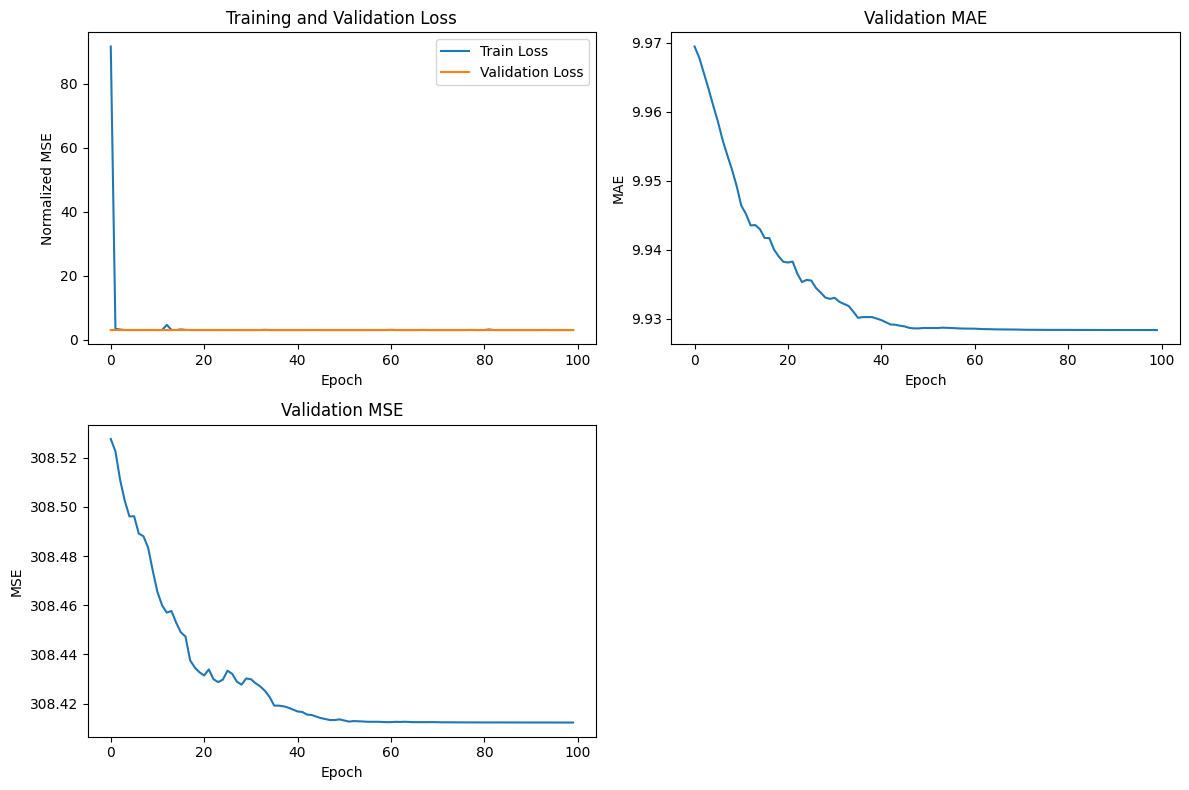

Testing: 100%|██████████| 66/66 [00:00<00:00, 139.42it/s]


In [ ]:
def train_model(model, train_dataloader, val_dataloader, device, num_epochs=100, early_stopping_patience=15):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # for storing metrics
    train_losses = []
    val_losses = []
    val_maes = []
    val_mses = []
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # Training loop ----------------
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            batch_x = None #[3200, 50, 6] --> input features, 3200 total sequences each length 50 with 6 features
            batch_y = None #[3840, 2] --> target features associated with input data 

            if isinstance(batch, tuple) or isinstance(batch, list):
                batch_x, batch_y = batch
                batch_y = batch_y.view(-1, 60, 2)
            else:
                batch = batch.to(device)
                batch_x = batch.x 
                batch_y = batch.y.view(batch.num_graphs, 60, 2) 
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            targets = batch.y.to(device)
            loss = criterion(outputs, batch_y)
            
            # Backward pass 
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        
        # Validation ----------------
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        num_val_samples = 0
        
        with torch.no_grad():
            for batch in tqdm.tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else:
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                batch_size = batch.num_graphs
                num_val_samples += batch_size
                
                # Forward pass
                outputs = model(batch_x)
                targets = batch.y.to(device)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_size
            
                scale_factor = batch.scale.view(-1, 1, 1).to(device)
                pred_unnormalized = outputs * scale_factor
                targets_unnormalized = targets.view(outputs.shape) * scale_factor

                mae = torch.abs(pred_unnormalized - targets_unnormalized).mean().item()
                mse = ((pred_unnormalized - targets_unnormalized) ** 2).mean().item()
                val_mae += mae * batch_size
                val_mse += mse * batch_size
        
        # do metric stuff
        val_loss /= num_val_samples
        val_mae /= num_val_samples
        val_mse /= num_val_samples
        
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        val_mses.append(val_mse)
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                tqdm.tqdm.write(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, val_maes, val_mses

# Create and train the MLP model
input_features = 50 * 50 * 6  # our data dimensions
output_features = 60 * 2      # 60 timestamps and 2 coordinates (x, y)

model = MLP(input_features, output_features)
model, train_losses, val_losses, val_maes, val_mses = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    device,
    num_epochs=100,
    early_stopping_patience=15
)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized MSE')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(val_maes)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')

plt.subplot(2, 2, 3)
plt.plot(val_mses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation MSE')

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), 'mlp_model.pth')

# For testing on test data
def test_model(model, test_dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloader, desc="Testing"):
            batch = batch.to(device)
            outputs = model(batch.x)
            
            # Unnormalize predictions
            scale_factor = batch.scale.view(-1, 1, 1).to(device)
            pred_unnormalized = outputs * scale_factor
            origin = batch.origin.to(device)  
            pred_unnormalized = pred_unnormalized + origin.view(-1, 1, 2)
            
            # Append to predictions list
            predictions.append(pred_unnormalized.cpu().numpy())
    
    all_predictions = np.concatenate(predictions, axis=0)
    return all_predictions

# run tests now 
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

test_predictions = test_model(model, test_dataloader, device)

Can see that MLP has much lower val MAE than linear regression (in the 9.9-10 range)! 

Alas, now we test the LSTM model.

In [23]:
# running the LSTM model
model = LSTM().to(device) 


# setting Adam with the parameters from Part A (ran with best parameters)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # You can try different schedulers

run_model_with_adam(model, optimizer, scheduler)



Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/1780213679.py:59: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   2%|▏         | 1/50 [00:06<05:05,  6.23s/epoch]

Epoch 000 | Learning rate 0.005000 | train normalized MSE   0.8825 | val normalized MSE   0.4166, | val MAE   2.4641 | val MSE  20.4139


Epoch:   4%|▍         | 2/50 [00:10<04:16,  5.34s/epoch]

Epoch 001 | Learning rate 0.005000 | train normalized MSE   0.3915 | val normalized MSE   0.3979, | val MAE   2.3917 | val MSE  19.4976


Epoch:   6%|▌         | 3/50 [00:15<03:52,  4.94s/epoch]

Epoch 002 | Learning rate 0.005000 | train normalized MSE   0.3497 | val normalized MSE   0.3200, | val MAE   2.1203 | val MSE  15.6807


Epoch:   8%|▊         | 4/50 [00:19<03:39,  4.78s/epoch]

Epoch 003 | Learning rate 0.005000 | train normalized MSE   0.3183 | val normalized MSE   0.2758, | val MAE   1.9326 | val MSE  13.5122


Epoch:  10%|█         | 5/50 [00:24<03:32,  4.72s/epoch]

Epoch 004 | Learning rate 0.005000 | train normalized MSE   0.2971 | val normalized MSE   0.2718, | val MAE   1.8995 | val MSE  13.3183


Epoch:  12%|█▏        | 6/50 [00:29<03:27,  4.71s/epoch]

Epoch 005 | Learning rate 0.005000 | train normalized MSE   0.2712 | val normalized MSE   0.2416, | val MAE   1.7790 | val MSE  11.8382


Epoch:  14%|█▍        | 7/50 [00:33<03:22,  4.70s/epoch]

Epoch 006 | Learning rate 0.005000 | train normalized MSE   0.2551 | val normalized MSE   0.2448, | val MAE   1.8591 | val MSE  11.9964


Epoch:  16%|█▌        | 8/50 [00:38<03:19,  4.74s/epoch]

Epoch 007 | Learning rate 0.005000 | train normalized MSE   0.2471 | val normalized MSE   0.2244, | val MAE   1.7467 | val MSE  10.9936


Epoch:  18%|█▊        | 9/50 [00:43<03:14,  4.75s/epoch]

Epoch 008 | Learning rate 0.005000 | train normalized MSE   0.2356 | val normalized MSE   0.2133, | val MAE   1.6523 | val MSE  10.4537


Epoch:  20%|██        | 10/50 [00:48<03:09,  4.74s/epoch]

Epoch 009 | Learning rate 0.002500 | train normalized MSE   0.2689 | val normalized MSE   0.2358, | val MAE   1.8523 | val MSE  11.5523


Epoch:  22%|██▏       | 11/50 [00:52<03:03,  4.72s/epoch]

Epoch 010 | Learning rate 0.002500 | train normalized MSE   0.2161 | val normalized MSE   0.2059, | val MAE   1.5263 | val MSE  10.0883


Epoch:  24%|██▍       | 12/50 [00:57<02:57,  4.68s/epoch]

Epoch 011 | Learning rate 0.002500 | train normalized MSE   0.2074 | val normalized MSE   0.2019, | val MAE   1.5572 | val MSE   9.8921


Epoch:  26%|██▌       | 13/50 [01:02<02:53,  4.68s/epoch]

Epoch 012 | Learning rate 0.002500 | train normalized MSE   0.2032 | val normalized MSE   0.1953, | val MAE   1.4866 | val MSE   9.5694


Epoch:  28%|██▊       | 14/50 [01:06<02:48,  4.67s/epoch]

Epoch 013 | Learning rate 0.002500 | train normalized MSE   0.2019 | val normalized MSE   0.1921, | val MAE   1.5037 | val MSE   9.4127


Epoch:  30%|███       | 15/50 [01:11<02:44,  4.69s/epoch]

Epoch 014 | Learning rate 0.002500 | train normalized MSE   0.1995 | val normalized MSE   0.1902, | val MAE   1.4642 | val MSE   9.3218


Epoch:  32%|███▏      | 16/50 [01:16<02:40,  4.73s/epoch]

Epoch 015 | Learning rate 0.002500 | train normalized MSE   0.1998 | val normalized MSE   0.1981, | val MAE   1.5966 | val MSE   9.7084


Epoch:  34%|███▍      | 17/50 [01:21<02:35,  4.71s/epoch]

Epoch 016 | Learning rate 0.002500 | train normalized MSE   0.1965 | val normalized MSE   0.1896, | val MAE   1.4800 | val MSE   9.2923


Epoch:  36%|███▌      | 18/50 [01:25<02:29,  4.67s/epoch]

Epoch 017 | Learning rate 0.002500 | train normalized MSE   0.1947 | val normalized MSE   0.1912, | val MAE   1.5272 | val MSE   9.3664


Epoch:  38%|███▊      | 19/50 [01:30<02:25,  4.68s/epoch]

Epoch 018 | Learning rate 0.002500 | train normalized MSE   0.1949 | val normalized MSE   0.1968, | val MAE   1.5331 | val MSE   9.6456


Epoch:  40%|████      | 20/50 [01:35<02:20,  4.68s/epoch]

Epoch 019 | Learning rate 0.001250 | train normalized MSE   0.1970 | val normalized MSE   0.1846, | val MAE   1.4772 | val MSE   9.0444


Epoch:  42%|████▏     | 21/50 [01:39<02:15,  4.68s/epoch]

Epoch 020 | Learning rate 0.001250 | train normalized MSE   0.1830 | val normalized MSE   0.1752, | val MAE   1.4007 | val MSE   8.5824


Epoch:  44%|████▍     | 22/50 [01:44<02:14,  4.80s/epoch]

Epoch 021 | Learning rate 0.001250 | train normalized MSE   0.1817 | val normalized MSE   0.1814, | val MAE   1.4576 | val MSE   8.8865


Epoch:  46%|████▌     | 23/50 [01:49<02:08,  4.76s/epoch]

Epoch 022 | Learning rate 0.001250 | train normalized MSE   0.1800 | val normalized MSE   0.1787, | val MAE   1.3890 | val MSE   8.7565


Epoch:  48%|████▊     | 24/50 [01:54<02:03,  4.74s/epoch]

Epoch 023 | Learning rate 0.001250 | train normalized MSE   0.1787 | val normalized MSE   0.1815, | val MAE   1.4392 | val MSE   8.8914


Epoch:  50%|█████     | 25/50 [01:58<01:59,  4.76s/epoch]

Epoch 024 | Learning rate 0.001250 | train normalized MSE   0.1794 | val normalized MSE   0.1788, | val MAE   1.4009 | val MSE   8.7628


Epoch:  52%|█████▏    | 26/50 [02:03<01:52,  4.71s/epoch]

Epoch 025 | Learning rate 0.001250 | train normalized MSE   0.1789 | val normalized MSE   0.1753, | val MAE   1.4199 | val MSE   8.5893


Epoch:  54%|█████▍    | 27/50 [02:08<01:47,  4.67s/epoch]

Epoch 026 | Learning rate 0.001250 | train normalized MSE   0.1764 | val normalized MSE   0.1771, | val MAE   1.4428 | val MSE   8.6783


Epoch:  56%|█████▌    | 28/50 [02:12<01:42,  4.68s/epoch]

Epoch 027 | Learning rate 0.001250 | train normalized MSE   0.1768 | val normalized MSE   0.1724, | val MAE   1.3996 | val MSE   8.4498


Epoch:  58%|█████▊    | 29/50 [02:17<01:37,  4.66s/epoch]

Epoch 028 | Learning rate 0.001250 | train normalized MSE   0.1782 | val normalized MSE   0.1750, | val MAE   1.3896 | val MSE   8.5759


Epoch:  60%|██████    | 30/50 [02:22<01:32,  4.65s/epoch]

Epoch 029 | Learning rate 0.000625 | train normalized MSE   0.1776 | val normalized MSE   0.1781, | val MAE   1.4039 | val MSE   8.7272


Epoch:  62%|██████▏   | 31/50 [02:26<01:28,  4.67s/epoch]

Epoch 030 | Learning rate 0.000625 | train normalized MSE   0.1725 | val normalized MSE   0.1717, | val MAE   1.3830 | val MSE   8.4151


Epoch:  64%|██████▍   | 32/50 [02:31<01:23,  4.66s/epoch]

Epoch 031 | Learning rate 0.000625 | train normalized MSE   0.1708 | val normalized MSE   0.1673, | val MAE   1.3545 | val MSE   8.1996


Epoch:  66%|██████▌   | 33/50 [02:36<01:19,  4.65s/epoch]

Epoch 032 | Learning rate 0.000625 | train normalized MSE   0.1695 | val normalized MSE   0.1688, | val MAE   1.3442 | val MSE   8.2703


Epoch:  68%|██████▊   | 34/50 [02:40<01:14,  4.65s/epoch]

Epoch 033 | Learning rate 0.000625 | train normalized MSE   0.1694 | val normalized MSE   0.1770, | val MAE   1.3630 | val MSE   8.6732


Epoch:  70%|███████   | 35/50 [02:45<01:11,  4.75s/epoch]

Epoch 034 | Learning rate 0.000625 | train normalized MSE   0.1689 | val normalized MSE   0.1726, | val MAE   1.3622 | val MSE   8.4556


Epoch:  72%|███████▏  | 36/50 [02:50<01:06,  4.73s/epoch]

Epoch 035 | Learning rate 0.000625 | train normalized MSE   0.1685 | val normalized MSE   0.1709, | val MAE   1.3654 | val MSE   8.3739


Epoch:  74%|███████▍  | 37/50 [02:55<01:01,  4.73s/epoch]

Epoch 036 | Learning rate 0.000625 | train normalized MSE   0.1680 | val normalized MSE   0.1690, | val MAE   1.3323 | val MSE   8.2814


Epoch:  76%|███████▌  | 38/50 [02:59<00:56,  4.71s/epoch]

Epoch 037 | Learning rate 0.000625 | train normalized MSE   0.1672 | val normalized MSE   0.1701, | val MAE   1.3563 | val MSE   8.3351


Epoch:  78%|███████▊  | 39/50 [03:04<00:51,  4.67s/epoch]

Epoch 038 | Learning rate 0.000625 | train normalized MSE   0.1676 | val normalized MSE   0.1684, | val MAE   1.3265 | val MSE   8.2496


Epoch:  80%|████████  | 40/50 [03:09<00:46,  4.67s/epoch]

Epoch 039 | Learning rate 0.000313 | train normalized MSE   0.1682 | val normalized MSE   0.1710, | val MAE   1.3575 | val MSE   8.3786


Epoch:  82%|████████▏ | 41/50 [03:13<00:42,  4.71s/epoch]

Epoch 040 | Learning rate 0.000313 | train normalized MSE   0.1660 | val normalized MSE   0.1659, | val MAE   1.3296 | val MSE   8.1304


Epoch:  84%|████████▍ | 42/50 [03:18<00:37,  4.68s/epoch]

Epoch 041 | Learning rate 0.000313 | train normalized MSE   0.1636 | val normalized MSE   0.1685, | val MAE   1.3175 | val MSE   8.2556


Epoch:  86%|████████▌ | 43/50 [03:23<00:33,  4.72s/epoch]

Epoch 042 | Learning rate 0.000313 | train normalized MSE   0.1634 | val normalized MSE   0.1687, | val MAE   1.3850 | val MSE   8.2645


Epoch:  88%|████████▊ | 44/50 [03:28<00:28,  4.75s/epoch]

Epoch 043 | Learning rate 0.000313 | train normalized MSE   0.1626 | val normalized MSE   0.1674, | val MAE   1.3394 | val MSE   8.2050


Epoch:  90%|█████████ | 45/50 [03:32<00:23,  4.72s/epoch]

Epoch 044 | Learning rate 0.000313 | train normalized MSE   0.1633 | val normalized MSE   0.1690, | val MAE   1.3458 | val MSE   8.2825


Epoch:  92%|█████████▏| 46/50 [03:37<00:18,  4.71s/epoch]

Epoch 045 | Learning rate 0.000313 | train normalized MSE   0.1620 | val normalized MSE   0.1675, | val MAE   1.3322 | val MSE   8.2062


Epoch:  94%|█████████▍| 47/50 [03:42<00:14,  4.73s/epoch]

Epoch 046 | Learning rate 0.000313 | train normalized MSE   0.1624 | val normalized MSE   0.1678, | val MAE   1.3541 | val MSE   8.2226


Epoch:  96%|█████████▌| 48/50 [03:46<00:09,  4.74s/epoch]

Epoch 047 | Learning rate 0.000313 | train normalized MSE   0.1628 | val normalized MSE   0.1663, | val MAE   1.3277 | val MSE   8.1493


Epoch:  98%|█████████▊| 49/50 [03:51<00:04,  4.71s/epoch]

Epoch 048 | Learning rate 0.000313 | train normalized MSE   0.1616 | val normalized MSE   0.1700, | val MAE   1.3681 | val MSE   8.3280


Epoch: 100%|██████████| 50/50 [03:56<00:00,  4.72s/epoch]

Epoch 049 | Learning rate 0.000156 | train normalized MSE   0.1616 | val normalized MSE   0.1682, | val MAE   1.3362 | val MSE   8.2403


LSTM with Adam optimizer got val MAE  down lowest out of the 3 models (in the 1.3 range) and the val MSE is also the lowest (8.2 range). 

In [83]:
# running the LSTM model
model = LSTM().to(device) 


# setting Adam with the parameters from Part A (ran with best average parameters)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # You can try different schedulers

run_model_with_adam(model, optimizer, scheduler)



Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/2808079002.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/k0/0k4d4ymn0d7_g9v6fws_l0j80000gn/T/ipykernel_257/2808079002.py:62: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   2%|▏         | 1/50 [00:02<01:38,  2.02s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   2.4924 | val normalized MSE   1.4101, | val MAE   7.1328 | val MSE 141.0084


Epoch:   4%|▍         | 2/50 [00:03<01:28,  1.85s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   1.0932 | val normalized MSE   0.7870, | val MAE   5.3799 | val MSE  78.6953


Epoch:   6%|▌         | 3/50 [00:05<01:24,  1.80s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.6250 | val normalized MSE   0.4409, | val MAE   3.7792 | val MSE  44.0908


Epoch:   8%|▊         | 4/50 [00:07<01:23,  1.81s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3863 | val normalized MSE   0.3318, | val MAE   3.2726 | val MSE  33.1819


Epoch:  10%|█         | 5/50 [00:09<01:21,  1.82s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2947 | val normalized MSE   0.2992, | val MAE   3.0995 | val MSE  29.9240


Epoch:  12%|█▏        | 6/50 [00:11<01:21,  1.86s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2741 | val normalized MSE   0.2693, | val MAE   2.9807 | val MSE  26.9334


Epoch:  14%|█▍        | 7/50 [00:12<01:19,  1.85s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2573 | val normalized MSE   0.2342, | val MAE   2.6024 | val MSE  23.4162


Epoch:  16%|█▌        | 8/50 [00:14<01:18,  1.86s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2403 | val normalized MSE   0.2282, | val MAE   2.6923 | val MSE  22.8225


Epoch:  18%|█▊        | 9/50 [00:16<01:15,  1.83s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2283 | val normalized MSE   0.2083, | val MAE   2.4731 | val MSE  20.8276


Epoch:  20%|██        | 10/50 [00:18<01:11,  1.79s/epoch]

Epoch 009 | Learning rate 0.000100 | train normalized MSE   0.2151 | val normalized MSE   0.2141, | val MAE   2.7046 | val MSE  21.4127


Epoch:  22%|██▏       | 11/50 [00:20<01:10,  1.80s/epoch]

Epoch 010 | Learning rate 0.000100 | train normalized MSE   0.1943 | val normalized MSE   0.1820, | val MAE   2.1960 | val MSE  18.2005


Epoch:  24%|██▍       | 12/50 [00:21<01:08,  1.80s/epoch]

Epoch 011 | Learning rate 0.000100 | train normalized MSE   0.1827 | val normalized MSE   0.1812, | val MAE   2.2297 | val MSE  18.1185


Epoch:  26%|██▌       | 13/50 [00:23<01:06,  1.79s/epoch]

Epoch 012 | Learning rate 0.000100 | train normalized MSE   0.1899 | val normalized MSE   0.1783, | val MAE   2.1908 | val MSE  17.8343


Epoch:  28%|██▊       | 14/50 [00:25<01:03,  1.78s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE   0.1856 | val normalized MSE   0.1750, | val MAE   2.2164 | val MSE  17.4963


Epoch:  30%|███       | 15/50 [00:27<01:01,  1.76s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE   0.1840 | val normalized MSE   0.1741, | val MAE   2.1970 | val MSE  17.4109


Epoch:  32%|███▏      | 16/50 [00:28<00:59,  1.76s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE   0.1816 | val normalized MSE   0.1743, | val MAE   2.2100 | val MSE  17.4331


Epoch:  34%|███▍      | 17/50 [00:30<00:58,  1.77s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE   0.1738 | val normalized MSE   0.1702, | val MAE   2.1649 | val MSE  17.0198


Epoch:  36%|███▌      | 18/50 [00:32<00:56,  1.77s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE   0.1792 | val normalized MSE   0.1686, | val MAE   2.1793 | val MSE  16.8618


Epoch:  38%|███▊      | 19/50 [00:34<00:54,  1.75s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE   0.1711 | val normalized MSE   0.1648, | val MAE   2.0887 | val MSE  16.4751


Epoch:  40%|████      | 20/50 [00:36<00:53,  1.79s/epoch]

Epoch 019 | Learning rate 0.000010 | train normalized MSE   0.1701 | val normalized MSE   0.1652, | val MAE   2.1061 | val MSE  16.5177


Epoch:  42%|████▏     | 21/50 [00:37<00:52,  1.82s/epoch]

Epoch 020 | Learning rate 0.000010 | train normalized MSE   0.1665 | val normalized MSE   0.1635, | val MAE   2.0729 | val MSE  16.3489


Epoch:  44%|████▍     | 22/50 [00:39<00:50,  1.81s/epoch]

Epoch 021 | Learning rate 0.000010 | train normalized MSE   0.1635 | val normalized MSE   0.1630, | val MAE   2.0753 | val MSE  16.3050


Epoch:  46%|████▌     | 23/50 [00:41<00:48,  1.78s/epoch]

Epoch 022 | Learning rate 0.000010 | train normalized MSE   0.1651 | val normalized MSE   0.1625, | val MAE   2.0662 | val MSE  16.2524


Epoch:  48%|████▊     | 24/50 [00:43<00:46,  1.77s/epoch]

Epoch 023 | Learning rate 0.000010 | train normalized MSE   0.1659 | val normalized MSE   0.1627, | val MAE   2.0714 | val MSE  16.2708


Epoch:  50%|█████     | 25/50 [00:44<00:44,  1.78s/epoch]

Epoch 024 | Learning rate 0.000010 | train normalized MSE   0.1637 | val normalized MSE   0.1628, | val MAE   2.0693 | val MSE  16.2787


Epoch:  52%|█████▏    | 26/50 [00:46<00:43,  1.80s/epoch]

Epoch 025 | Learning rate 0.000010 | train normalized MSE   0.1644 | val normalized MSE   0.1623, | val MAE   2.0688 | val MSE  16.2265


Epoch:  54%|█████▍    | 27/50 [00:48<00:41,  1.80s/epoch]

Epoch 026 | Learning rate 0.000010 | train normalized MSE   0.1676 | val normalized MSE   0.1617, | val MAE   2.0704 | val MSE  16.1691


Epoch:  56%|█████▌    | 28/50 [00:50<00:39,  1.78s/epoch]

Epoch 027 | Learning rate 0.000010 | train normalized MSE   0.1691 | val normalized MSE   0.1625, | val MAE   2.0760 | val MSE  16.2547


Epoch:  58%|█████▊    | 29/50 [00:52<00:36,  1.76s/epoch]

Epoch 028 | Learning rate 0.000010 | train normalized MSE   0.1636 | val normalized MSE   0.1622, | val MAE   2.0852 | val MSE  16.2237


Epoch:  60%|██████    | 30/50 [00:53<00:35,  1.77s/epoch]

Epoch 029 | Learning rate 0.000001 | train normalized MSE   0.1673 | val normalized MSE   0.1620, | val MAE   2.0665 | val MSE  16.1993


Epoch:  62%|██████▏   | 31/50 [00:55<00:34,  1.79s/epoch]

Epoch 030 | Learning rate 0.000001 | train normalized MSE   0.1649 | val normalized MSE   0.1619, | val MAE   2.0650 | val MSE  16.1935


Epoch:  64%|██████▍   | 32/50 [00:57<00:32,  1.80s/epoch]

Epoch 031 | Learning rate 0.000001 | train normalized MSE   0.1673 | val normalized MSE   0.1618, | val MAE   2.0657 | val MSE  16.1829


Epoch:  66%|██████▌   | 33/50 [00:59<00:30,  1.78s/epoch]

Epoch 032 | Learning rate 0.000001 | train normalized MSE   0.1676 | val normalized MSE   0.1618, | val MAE   2.0663 | val MSE  16.1760


Epoch:  68%|██████▊   | 34/50 [01:01<00:28,  1.78s/epoch]

Epoch 033 | Learning rate 0.000001 | train normalized MSE   0.1633 | val normalized MSE   0.1617, | val MAE   2.0670 | val MSE  16.1738


Epoch:  70%|███████   | 35/50 [01:02<00:26,  1.78s/epoch]

Epoch 034 | Learning rate 0.000001 | train normalized MSE   0.1646 | val normalized MSE   0.1616, | val MAE   2.0669 | val MSE  16.1583


Epoch:  70%|███████   | 35/50 [01:04<00:27,  1.85s/epoch]

Epoch 035 | Learning rate 0.000001 | train normalized MSE   0.1636 | val normalized MSE   0.1614, | val MAE   2.0655 | val MSE  16.1394
Early stop!
